# Proyek Akhir : Membuat Model Sistem Rekomendasi

Nama : Alivia Vinca Kustaryono

Cohort ID : MC006D5X2041

Email : mc006d5x2041@student.devacademy.id

# Data Loading

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from zipfile import ZipFile

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')


## Upload dan ekstrak dataset

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mc006d5x2041","key":"9cbfefc7928603e51e693b7df8e126d6"}'}

In [ ]:
# Download kaggle dataset dan unzip file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d CooperUnion/anime-recommendations-database

Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
  0% 0.00/25.0M [00:00<?, ?B/s]
100% 25.0M/25.0M [00:00<00:00, 697MB/s]


In [ ]:
!unzip anime-recommendations-database.zip

Archive:  anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


## Load Dataset

In [ ]:
# Baca dataset CSV
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

In [ ]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


# Exploratory Data Analysis (EDA)

## Struktur Data

In [ ]:
# Cek informasi dataset
anime.info()
print('-----------------------------------------------------------')
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
-----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [ ]:
# Cek jumlah baris dan kolom
print(anime.shape)
print('-----------------------------------------------------------')
print(rating.shape)

(12294, 7)
-----------------------------------------------------------
(7813737, 3)


In [ ]:
# Statistik deskriptif
anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [ ]:
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [ ]:
# Cek data kosong
anime.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


In [ ]:
rating.isnull().sum()

,0
user_id,0
anime_id,0
rating,0


In [ ]:
# Cek jumlah data duplikat
anime.duplicated().sum()

np.int64(0)

In [ ]:
rating.duplicated().sum()

np.int64(1)

## Visualisasi Genre dan Tipe Anime

In [ ]:
# Menghitung genre anime
genres = anime['genre'].dropna().str.cat(sep=',').split(',')
genres = pd.Series(genres).value_counts()
genres.head(20)

,count
Comedy,3193
Action,2845
Sci-Fi,1986
Fantasy,1815
Shounen,1663
Adventure,1457
Comedy,1452
Romance,1371
Kids,1213
School,1170


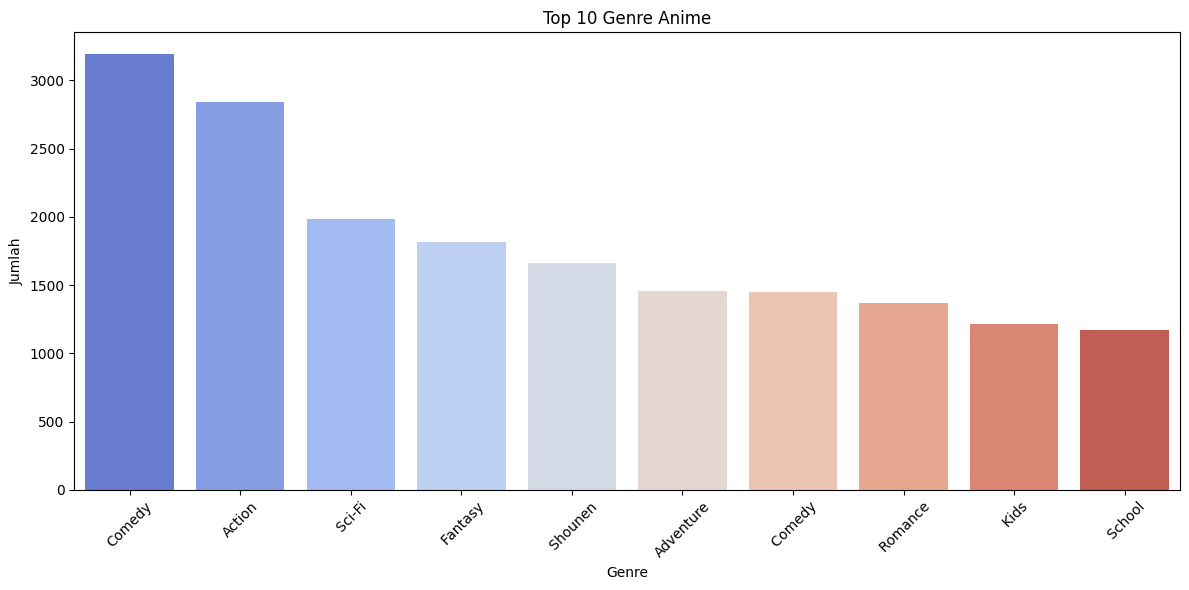

In [ ]:
# Visualisasi genre anime
plt.figure(figsize=(12, 6))
sns.barplot(
    x=genres.head(10).index,
    y=genres.head(10).values,
    palette=sns.color_palette("coolwarm", n_colors=10)
)
plt.title('Top 10 Genre Anime')
plt.xlabel('Genre')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Menghitung tipe anime
tipe_anime = anime['type'].value_counts()
tipe_anime

,count
type,
TV,3787
OVA,3311
Movie,2348
Special,1676
ONA,659
Music,488


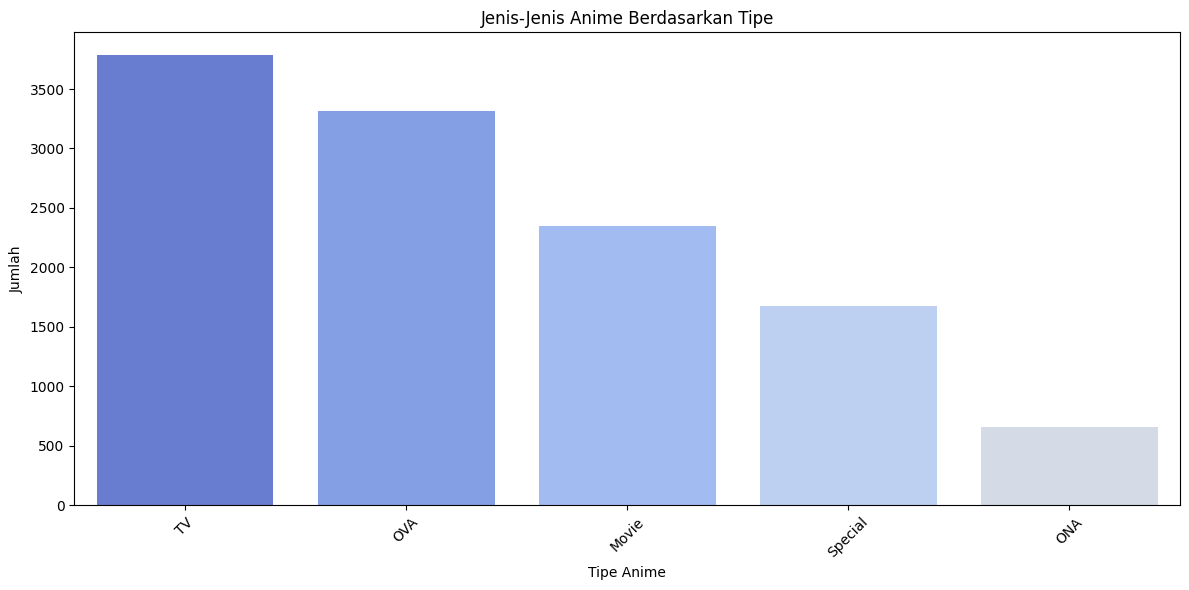

In [ ]:
# Visualisasi tipe anime
plt.figure(figsize=(12, 6))
sns.barplot(
    x=tipe_anime.head().index,
    y=tipe_anime.head().values,
    palette=sns.color_palette("coolwarm", n_colors=10)
)
plt.title('Jenis-Jenis Anime Berdasarkan Tipe')
plt.xlabel('Tipe Anime')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Data Preprocessing

1. Sampling 500000 Rating

In [ ]:
# Sampling 500000 Rating
rating_sample = rating.sample(n=500000, random_state=42)

In [ ]:
rating_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 7806172 to 3489996
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   500000 non-null  int64
 1   anime_id  500000 non-null  int64
 2   rating    500000 non-null  int64
dtypes: int64(3)
memory usage: 15.3 MB


In [ ]:
rating_sample.head()

,user_id,anime_id,rating
7806172,73424,7785,10
6470262,59789,19769,6
5975474,55960,59,10
7617688,71461,3342,10
5932334,55390,986,8


2. Mengisi kolom kosong pada dataset anime

In [ ]:
# Mengisi kolom kosong

# Isi missing value pada kolom 'genre' dengan 'Unknown'
anime['genre'] = anime['genre'].fillna('Unknown')

# Isi missing value pada kolom 'type' dengan 'Unknown'
anime['type'] = anime['type'].fillna('Unknown')

# Isi missing value pada kolom 'rating' dengan 0.00
anime['rating'] = anime['rating'].fillna(0.00)


In [ ]:
anime.isnull().sum()

,0
anime_id,0
name,0
genre,0
type,0
episodes,0
rating,0
members,0


3. Membersihkan nama anime dari karakter non-alfabetnumerik

In [ ]:
# Membersihkan Nama Anime
anime['name'] = anime['name'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

In [ ]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,SteinsGate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


# Model Development Content Based Filtering

Standarisasi genre anime sebelum melakukan TF-IDF

In [ ]:
# Standarisasi genre anime
anime['genre'] = anime['genre'].str.replace(', ', ' ')

In [ ]:
# Gabungkan semua genre tanpa mengambil hanya genre pertama
anime['genre'] = anime['genre'].fillna('Unknown')

In [ ]:
# Hapus duplikat berdasarkan nama anime
anime = anime.drop_duplicates(subset='name')

In [ ]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,Drama Romance School Supernatural,Movie,1,9.37,200630
1,5114,Fullmetal Alchemist Brotherhood,Action Adventure Drama Fantasy Magic Military ...,TV,64,9.26,793665
2,28977,Gintama,Action Comedy Historical Parody Samurai Sci-Fi...,TV,51,9.25,114262
3,9253,SteinsGate,Sci-Fi Thriller,TV,24,9.17,673572
4,9969,Gintama039,Action Comedy Historical Parody Samurai Sci-Fi...,TV,51,9.16,151266


In [ ]:
# Menampilkan data kolom nama dan genre
anime[['name','genre']].head()

,name,genre
0,Kimi no Na wa,Drama Romance School Supernatural
1,Fullmetal Alchemist Brotherhood,Action Adventure Drama Fantasy Magic Military ...
2,Gintama,Action Comedy Historical Parody Samurai Sci-Fi...
3,SteinsGate,Sci-Fi Thriller
4,Gintama039,Action Comedy Historical Parody Samurai Sci-Fi...


## TF-IDF Vectorizer

In [ ]:
# Inisialisasi TfidfVectorizer
tfidf = TfidfVectorizer()

# TF-IDF vectorization menggunakan semua genre
tfidf = TfidfVectorizer(token_pattern=r"(?u)\b\w[\w&\-]+\b")  # menangani genre seperti "Sci-Fi", "Slice of Life"

# Melakukan perhitungan idf pada data genre
tfidf.fit(anime['genre'])

# Mapping array dari fitur index integer ke fitur nama
tfidf.get_feature_names_out()

array(['action', 'adventure', 'ai', 'arts', 'cars', 'comedy', 'dementia',
       'demons', 'drama', 'ecchi', 'fantasy', 'game', 'harem', 'hentai',
       'historical', 'horror', 'josei', 'kids', 'life', 'magic',
       'martial', 'mecha', 'military', 'music', 'mystery', 'of', 'parody',
       'police', 'power', 'psychological', 'romance', 'samurai', 'school',
       'sci-fi', 'seinen', 'shoujo', 'shounen', 'slice', 'space',
       'sports', 'super', 'supernatural', 'thriller', 'unknown',
       'vampire', 'yaoi', 'yuri'], dtype=object)

In [ ]:
# Transformasi genre ke bentuk matriks TF-IDF
tfidf_matrix = tfidf.fit_transform(anime['genre'])

# Melihat ukuran matriks TF-IDF
print("Ukuran Matrix TF-IDF:", tfidf_matrix.shape)

Ukuran Matrix TF-IDF: (12267, 47)


In [ ]:
# Mengubah vektor TF-IDF dalam bentuk matriks
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.29463604, 0.31758443, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.26106211, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
# Membuat dataframe untuk melihat matrix TF-IDF
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=anime['name']
)

,action,adventure,ai,arts,cars,comedy,dementia,demons,drama,ecchi,...,slice,space,sports,super,supernatural,thriller,unknown,vampire,yaoi,yuri
name,,,,,,,,,,,,,,,,,,,,,
Kimi no Na wa,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.439923,0.0,...,0.0,0.0,0.0,0.0,0.54396,0.000000,0.0,0.0,0.0,0.0
Fullmetal Alchemist Brotherhood,0.294636,0.317584,0.0,0.0,0.0,0.000000,0.0,0.0,0.335842,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
Gintama,0.261062,0.000000,0.0,0.0,0.0,0.209459,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
SteinsGate,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.905648,0.0,0.0,0.0,0.0
Gintama039,0.261062,0.000000,0.0,0.0,0.0,0.209459,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Toushindai My Lover Minami tai MechaMinami,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
Under World,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
Violence Gekiga David no Hoshi,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0


### Cosine Similarity

In [ ]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.14774461, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14774461, 1.        , 0.18634744, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.18634744, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [ ]:
# Membuat dataframe cosine similiarity antar anime
cosine_sim_df = pd.DataFrame(cosine_sim, index=anime['name'], columns=anime['name'])

# Menampilkan ukuran matriks cosine similiarity
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap anime
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (12267, 12267)


name,Doukyuusei OVA Climax,Rumiko Takahashi Anthology,Esper Bishoujo Manami,Watashi no Coffee Samurai Jihankiteki na Kareshi,Paniponi Dash
name,,,,,
Kimi ga Nozomu Eien Gundam Parody,0.0,0.000000,0.0,0.137307,0.428760
Kagachisama Onagusame Tatematsurimasu Netorare Mura Inya Hanashi The Animation,1.0,0.000000,1.0,0.000000,0.000000
Esper Bishoujo Manami,1.0,0.000000,1.0,0.000000,0.000000
Mazinger Z tai Devilman,0.0,0.129998,0.0,0.138886,0.000000
Pumpkin Scissors,0.0,0.223719,0.0,0.137320,0.109767
Gun x Swordsan,0.0,0.000000,0.0,0.118102,0.470000
Mobile Suit Gundam MS IGLOO 2 Gravity of the Battlefront,0.0,0.000000,0.0,0.234973,0.000000
Patapata Hikousen no Bouken,0.0,0.000000,0.0,0.276353,0.000000
Ganbare Kickers Hitoribocchi no Ace Striker,0.0,0.328917,0.0,0.000000,0.000000


### Mendapatkan Rekomendasi

In [ ]:
def anime_recommendations(anime_name, similarity_data=cosine_sim_df, items=anime[['name', 'genre']], k=5):
    """
    Rekomendasi Anime berdasarkan kemiripan dataframe

    Parameter:
    ---
    nama_anime : tipe data string (str)
                 Nama Anime (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetris, dengan anime sebagai indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---

    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,anime_name].to_numpy().argpartition(range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_movie agar nama movie yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(anime_name, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [ ]:
# Cek data anime
anime[anime['name'].eq('Saiki Kusuo no nan TV')]

,anime_id,name,genre,type,episodes,rating,members
232,33255,Saiki Kusuo no nan TV,Comedy School Shounen Supernatural,TV,120,8.29,47092


In [ ]:
# Mendapatkan rekomendasi anime mirip dengan anime yang di panggil
anime_recommendations('Saiki Kusuo no nan TV')

,name,genre
0,Honto ni Atta Reibai Sensei,Comedy School Shounen Supernatural
1,Kannagi Moshimo Kannagi ga Attara,Comedy School Shounen Supernatural
2,Gabriel DropOut,Comedy School Shounen Supernatural
3,Yamadakun to 7nin no Majo,Comedy School Shounen Supernatural
4,Wangpai Yushi Di 0 Ji,Comedy Fantasy School Shounen Supernatural


Mendapatkan Rekomendasi dengan menuliskan sebagian teks judul anime

In [ ]:
from difflib import get_close_matches

def get_closest_anime(anime_input, anime_list):
    matches = get_close_matches(anime_input, anime_list, n=1, cutoff=0.6)
    return matches[0] if matches else None

In [ ]:
# Input judul
anime_input = input("Masukkan judul anime: ")
matched_anime = get_closest_anime(anime_input, anime['name'].tolist())

if matched_anime:
    print(f"Menampilkan rekomendasi untuk: {matched_anime}")
    display(anime_recommendations(matched_anime))
else:
    print("Anime tidak ditemukan.")


Masukkan judul anime: Sword Art On
Menampilkan rekomendasi untuk: Sword Art Online


,name,genre
0,Sword Art Online Extra Edition,Action Adventure Fantasy Game Romance
1,Sword Art Online Movie Ordinal Scale,Action Adventure Fantasy Game Romance
2,Sword Art Online II,Action Adventure Fantasy Game Romance
3,Ys IV The Dawn of Ys,Action Adventure Fantasy Game
4,Slime Boukenki Umi da Yeah,Action Adventure Comedy Fantasy Game


### Evaluasi Model Content-Based Filtering

Evaluasi ini menggunakan Precision@5 (dari anime_recomendation)

In [ ]:
# Misalnya user menyukai ini
actual_liked = ['Mob Psycho 100', 'Gintama', 'Saiki Kusuo no nan TV', 'One Punch Man']


In [ ]:
recommended_df = anime_recommendations('Saiki Kusuo no nan TV')
recommended = recommended_df['name'].tolist()
print("Recommended:", recommended)

# Hitung precision@5
def precision_at_k(recommended, actual, k=5):
    recommended_at_k = recommended[:k]
    true_positive = len(set(recommended_at_k) & set(actual))
    return true_positive / k

precision = precision_at_k(recommended, actual_liked, k=5)
print(f"Precision@5: {precision:.2f}")


Recommended: ['Honto ni Atta Reibai Sensei', 'Kannagi Moshimo Kannagi ga Attara', 'Gabriel DropOut', 'Yamadakun to 7nin no Majo', 'Wangpai Yushi Di 0 Ji']
Precision@5: 0.00


Evaluasi ini menggunakan Precision@5 (Manual)

In [ ]:
# Contoh data sederhana untuk satu user
user_id = 1
recommended_animes = ['Naruto', 'One Piece', 'Bleach', 'Attack on Titan', 'Demon Slayer']  # Hasil dari CBF
actual_liked_animes = ['Naruto', 'Attack on Titan', 'Jujutsu Kaisen']  # Ground truth (misalnya dari rating > 7)

# Precision@5
true_positive = len(set(recommended_animes) & set(actual_liked_animes))
precision_at_5 = true_positive / len(recommended_animes)

print(f"Precision@5 untuk user {user_id}: {precision_at_5:.4f}")


Precision@5 untuk user 1: 0.4000


In [ ]:
def precision_at_k(recommended, actual, k):
    recommended_at_k = recommended[:k]
    true_positive = len(set(recommended_at_k) & set(actual))
    return true_positive / k

# Contoh per user
all_users = {
    1: {
        'recommended': ['Naruto', 'One Piece', 'Bleach', 'Attack on Titan', 'Demon Slayer'],
        'actual': ['Naruto', 'Attack on Titan', 'Jujutsu Kaisen']
    },
    2: {
        'recommended': ['Your Name', 'Silent Voice', 'Weathering with You', 'Spirited Away', 'I Want to Eat Your Pancreas'],
        'actual': ['Your Name', 'Weathering with You']
    }
}

precision_scores = []

for user_id, data in all_users.items():
    prec = precision_at_k(data['recommended'], data['actual'], k=5)
    print(f"User {user_id} Precision@5: {prec:.4f}")
    precision_scores.append(prec)

avg_precision = sum(precision_scores) / len(precision_scores)
print(f"\nRata-rata Precision@5: {avg_precision:.4f}")


User 1 Precision@5: 0.4000
User 2 Precision@5: 0.4000

Rata-rata Precision@5: 0.4000


# Model Development dengan Collaborative Filtering

In [ ]:
# Menampilkan data rating yang sudah di sampling
rating_sample.head()

,user_id,anime_id,rating
7806172,73424,7785,10
6470262,59789,19769,6
5975474,55960,59,10
7617688,71461,3342,10
5932334,55390,986,8


### Data Preparation

In [ ]:
#Filter rating

# Hapus rating yang tidak valid (−1)
rating_sample = rating_sample[rating_sample['rating'] != -1]

# Mengambil anime dari dataset anime
rating_sample = rating_sample[rating_sample['anime_id'].isin(anime['anime_id'])]

# Filter user dengan minimal 5 rating
user_counts = rating_sample['user_id'].value_counts()
active_users = user_counts[user_counts >= 5].index
rating_sample = rating_sample[rating_sample['user_id'].isin(active_users)]

# Reset index setelah filter
rating_sample.reset_index(drop=True, inplace=True)

# Info data setelah preprocessing
print("Shape anime:", anime.shape)
print("Shape rating_sample:", rating_sample.shape)
print("Sample rating_sample:")
print(rating_sample.head())


Shape anime: (12267, 7)
Shape rating_sample: (343270, 3)
Sample rating_sample:
   user_id  anime_id  rating
0    73424      7785      10
1    59789     19769       6
2    55960        59      10
3    71461      3342      10
4    55390       986       8


In [ ]:
# Encode user_id dan anime_id menjadi index numerik
user_ids = rating_sample['user_id'].unique().tolist()
anime_ids = rating_sample['anime_id'].unique().tolist()

user2user_encoded = {x: i for i, x in enumerate(user_ids)}
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}

rating_sample['user'] = rating_sample['user_id'].map(user2user_encoded)
rating_sample['anime'] = rating_sample['anime_id'].map(anime2anime_encoded)

# Tentukan jumlah user dan anime
num_users = len(user2user_encoded)
num_anime = len(anime2anime_encoded)

print(f'Jumlah users: {num_users}, Jumlah anime: {num_anime}')

Jumlah users: 26122, Jumlah anime: 7264


### Membagi Data untuk Training dan Validasi

In [ ]:
# Split data train dan validasi

# Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value
x = rating_sample[['user', 'anime']].values

# Membuat variabel y untuk membuat rating dari hasil
y = rating_sample['rating'].values

print(f"Jumlah rating akhir: {rating_sample.shape[0]}")

# Membagi menjadi 80% data train dan 20% data validasi
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(x, y)

Jumlah rating akhir: 343270
x_train shape: (274616, 2)
y_train shape: (274616,)
x_val shape: (68654, 2)
y_val shape: (68654,)
[[    0     0]
 [    1     1]
 [    2     2]
 ...
 [ 4165  1231]
 [ 7916  2027]
 [22663  1354]] [10  6 10 ...  5  7 10]


### Proses Training

In [ ]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size

    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.anime_embedding = layers.Embedding( # layer embeddings movie
        num_anime,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.anime_bias = layers.Embedding(num_anime, 1) # layer embedding movie bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    anime_vector = self.anime_embedding(inputs[:, 1]) # memanggil layer embedding 3
    anime_bias = self.anime_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_anime = tf.tensordot(user_vector, anime_vector, 2)

    x = dot_user_anime + user_bias + anime_bias
    # Menggunakan sigmoid hanya jika output rating 0-1.
    # Jika rating 1-10, jangan gunakan sigmoid dan pertimbangkan Mean Squared Error sebagai loss.
    return x

In [ ]:
model = RecommenderNet(num_users, num_anime, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

### Training model

In [ ]:
# Training Training Model
print("\nMemulai proses training model...")
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128, # Ukuran batch yang lebih kecil dari tf.data.Dataset batch (1024)
                    # karena ini adalah batch untuk proses training di Keras fit
    epochs=10,      # Jumlah epoch, sesuaikan sesuai kebutuhan dan kinerja
    validation_data=(x_val, y_val),
    verbose=1       # Menampilkan progress training
)
print("\nProses training selesai.")



Memulai proses training model...
Epoch 1/10
2146/2146 ━━━━━━━━━━━━━━━━━━━━ 52s 23ms/step - loss: 42.6245 - root_mean_squared_error: 6.4206 - val_loss: 2.7576 - val_root_mean_squared_error: 1.6600
Epoch 2/10
2146/2146 ━━━━━━━━━━━━━━━━━━━━ 83s 23ms/step - loss: 2.6904 - root_mean_squared_error: 1.6381 - val_loss: 4.0539 - val_root_mean_squared_error: 2.0127
Epoch 3/10
2146/2146 ━━━━━━━━━━━━━━━━━━━━ 80s 23ms/step - loss: 2.6513 - root_mean_squared_error: 1.6271 - val_loss: 3.7128 - val_root_mean_squared_error: 1.9255
Epoch 4/10
2146/2146 ━━━━━━━━━━━━━━━━━━━━ 81s 22ms/step - loss: 2.8700 - root_mean_squared_error: 1.6923 - val_loss: 4.8558 - val_root_mean_squared_error: 2.2019
Epoch 5/10
2146/2146 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - loss: 3.1349 - root_mean_squared_error: 1.7682 - val_loss: 4.3749 - val_root_mean_squared_error: 2.0894
Epoch 6/10
2146/2146 ━━━━━━━━━━━━━━━━━━━━ 83s 23ms/step - loss: 3.2810 - root_mean_squared_error: 1.8085 - val_loss: 5.1319 - val_root_mean_squared_error: 

In [ ]:
# Hasil Evaluasi dengan MSE & RMSE
results = model.evaluate(x_val, y_val, verbose=1)

print("\nHasil Evaluasi pada Data Validasi:")
print(f"Loss (MSE): {results[0]:.4f}")
print(f"RMSE: {results[1]:.4f}")

2146/2146 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 36.4568 - root_mean_squared_error: 6.0364

Hasil Evaluasi pada Data Validasi:
Loss (MSE): 36.3658
RMSE: 6.0290


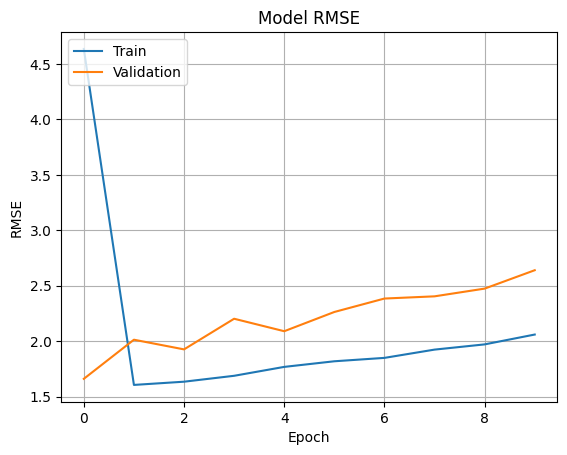

In [ ]:
# Visualisasi metrik
def plot_rmse(history):
    plt.plot(history.history['root_mean_squared_error'])
    plt.plot(history.history['val_root_mean_squared_error'])
    plt.title('Model RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)
    plt.show()
plot_rmse(history)

### Mendapatkan Rekomendasi

In [ ]:
anime_df = anime.copy()
rating_df = rating_sample.copy()

# Mengambil sample user
userId = rating_sample.user_id.sample(1).iloc[0]
anime_watched_by_user = rating_sample[rating_sample.user_id == userId]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
anime_not_watched_ids = anime_df[~anime_df['anime_id'].isin(anime_watched_by_user.anime_id.values)]['anime_id']
encoded_user_id = user2user_encoded[userId]
encoded_anime_not_watched = [anime2anime_encoded.get(anime_id) for anime_id in anime_not_watched_ids if anime_id in anime2anime_encoded]

user_anime_array = np.hstack((
    np.array([[encoded_user_id]] * len(encoded_anime_not_watched)),
    np.array(encoded_anime_not_watched).reshape(-1, 1)
))

In [ ]:
ratings = model.predict(user_anime_array).flatten()

# Ambil indeks dengan prediksi rating tertinggi
top_ratings_indices = ratings.argsort()[-10:][::-1]

# Karena kita pakai ID asli, ambil langsung dari anime_not_watched
recommended_anime_ids = [anime_not_watched_ids.iloc[x] for x in top_ratings_indices]

print('Showing recommendations for user:', userId)
print('===' * 9)
print('Anime with high ratings from user')
print('----' * 8)

# Ambil 5 anime dengan rating tertinggi dari user tersebut
top_anime_user_ids = (
    anime_watched_by_user.sort_values(
        by='rating',
        ascending=False
    )
    .head(5)
    .anime_id.values
)

# Tampilkan anime yang sudah pernah ditonton dan disukai user
anime_df_rows = anime_df[anime_df['anime_id'].isin(top_anime_user_ids)]
for row in anime_df_rows.itertuples():
    print(row.name, ':', row.genre)

print('----' * 8)
print('Top 10 anime recommendation')
print('----' * 8)

# Tampilkan anime hasil rekomendasi model
recommended_anime = anime_df[anime_df['anime_id'].isin(recommended_anime_ids)]
for row in recommended_anime.itertuples():
    print(row.name, ':', row.genre)

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Showing recommendations for user: 35778
Anime with high ratings from user
--------------------------------
Fullmetal Alchemist Brotherhood : Action Adventure Drama Fantasy Magic Military Shounen
Tonari no Totoro : Adventure Comedy Supernatural
Evangelion 10 You Are Not Alone : Action Mecha Sci-Fi
Naruto : Action Comedy Martial Arts Shounen Super Power
Houkago no Pleiades TV : Magic Space
--------------------------------
Top 10 anime recommendation
--------------------------------
Kimi no Na wa : Drama Romance School Supernatural
Gintama : Action Comedy Historical Parody Samurai Sci-Fi Shounen
SteinsGate : Sci-Fi Thriller
Gintama039 : Action Comedy Historical Parody Samurai Sci-Fi Shounen
Hunter x Hunter 2011 : Action Adventure Shounen Super Power
Gintama Movie Kanketsuhen  Yorozuya yo Eien Nare : Action Comedy Historical Parody Samurai Sci-Fi Shounen
Clannad After Story : Drama Fantasy Romance Slice of Life Supernatural
Code Geass Hangyaku no Le